# Cats versus Dogs
Exploring optimization impact on size, performance and accuracy!

**For best performance on this Colab make sure you are using a GPU runtime!** The runtime can be changed by selecting: ```runtime -> change runtime type``` and selecting GPU from the hardware accelerator dropdown.

### We start by importing TensorFlow and our Dataset
And splitting our dataset into batches.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# format images to have normalized pixels
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

# load in our dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# display how much data we have
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print(num_examples)
print(num_classes)

# split the data in training, validation, and test datasets
BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

# display the shape of our data
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteK27XKZ/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
23262
2


TensorShape([32, 224, 224, 3])

### We next define our (pre-trained) model

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### We then train and save our model
Since we are doing transfer learning to fine tune a pre-trained model to our dataset we only need to use 5 Epochs. We will explore transfer learning in detail and study how, why, and where it works later in this course!

In [4]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 69s 55ms/step - loss: 0.0860 - accuracy: 0.9719 - val_loss: 0.0389 - val_accuracy: 0.9858
Epoch 2/5
582/582 [==============================] - 34s 52ms/step - loss: 0.0320 - accuracy: 0.9897 - val_loss: 0.0371 - val_accuracy: 0.9884
Epoch 3/5
582/582 [==============================] - 34s 52ms/step - loss: 0.0247 - accuracy: 0.9922 - val_loss: 0.0400 - val_accuracy: 0.9875
Epoch 4/5
582/582 [==============================] - 34s 52ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.0442 - val_accuracy: 0.9862
Epoch 5/5
582/582 [==============================] - 34s 52ms/step - loss: 0.0197 - accuracy: 0.9925 - val_loss: 0.0440 - val_accuracy: 0.9854


In [5]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


### Optimizing the models in 3 steps:
  model1, model2, model3


In [6]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model1.tflite' 
tflite_model_file.write_bytes(tflite_model)

8857848

In [7]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

converter.optimizations = [tf.lite.Optimize.DEFAULT]    # Uncomment this line for Model 2 and Model 3

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model2.tflite' 
tflite_model_file.write_bytes(tflite_model)

2629648

In [9]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

converter.optimizations = [tf.lite.Optimize.DEFAULT]    # Uncomment this line for Model 2 and Model 3

def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
    for input_value, _ in test_batches.take(100):
        yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model3.tflite'     # Change the filename here for Model2 and Model3!
tflite_model_file.write_bytes(tflite_model)

2835952

  * Without any optimizations we get - 8857848  (model1.tflite)
  * With the .optimizations property set we get 2629648 (model2.tflite)
  * With the .optimizations property and representative data set we get 2835952. Slightly larger!  (model3.tflite)

Now we will test the accuracy of the three models! After you run each model you will get the number of correct predictions and then you can plot which images were correct/incorrect!
+ Run this code
+ Change the model file to model2.tflite and run it again
+ Change the model file to model3.tflite and run it again

In [11]:
#@title Run this cell each time to test your model's accuracy (make sure to change the filename)
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = '/tmp/model1.tflite'                 # Change the filename here for Model 2 and 3
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

score = 0
for item in range(0,100):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]

Out of 100 predictions I got 100 correct


In [12]:
#@title Define utility functions once for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

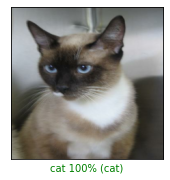

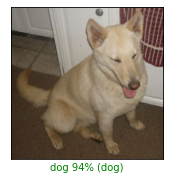

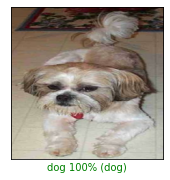

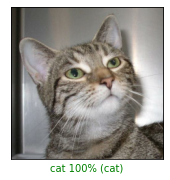

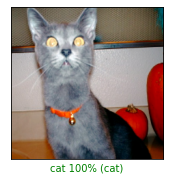

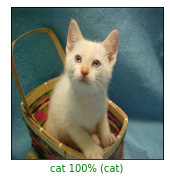

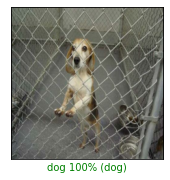

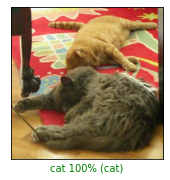

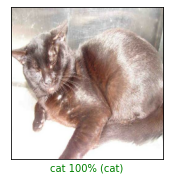

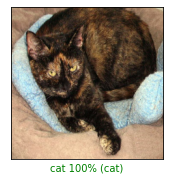

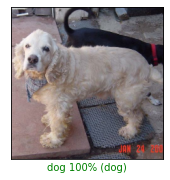

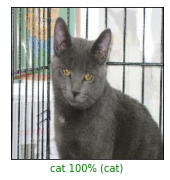

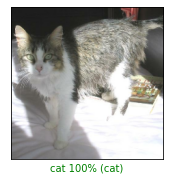

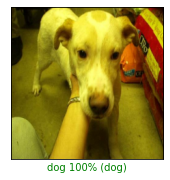

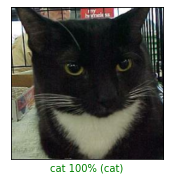

In [13]:
#@title Visualize the outputs each time { run: "auto" }
max_index = 15 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()